In [1]:
# Import necessary libraries
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from scipy.special import softmax


In [2]:
# Updated data loading function with train-validation split
def load_data(validation_split=0.2):
    # Load training and test data
    train_data = FashionMNIST(root=".", train=True, download=True, transform=ToTensor())
    test_data = FashionMNIST(root=".", train=False, download=True, transform=ToTensor())
    
    # Convert to numpy arrays
    X_train = np.array([np.array(img[0]).flatten() for img in train_data])
    y_train = np.array(train_data.targets)
    X_test = np.array([np.array(img[0]).flatten() for img in test_data])
    y_test = np.array(test_data.targets)
    
    # Split training data into train and validation sets
    num_train_samples = int((1 - validation_split) * X_train.shape[0])
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    
    X_train, X_val = X_train[indices[:num_train_samples]], X_train[indices[num_train_samples:]]
    y_train, y_val = y_train[indices[:num_train_samples]], y_train[indices[num_train_samples:]]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Load the data with 20% validation split
X_train, y_train, X_val, y_val, X_test, y_test = load_data()


In [3]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        # Initialize weights and biases
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))
    
    def forward(self, X):
        # Store input for use in backpropagation
        self.X = X
        return np.dot(X, self.weights) + self.bias
    
    def backward(self, grad_output, learning_rate):
        # Compute gradients
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.X.T, grad_output)
        grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        
        # Update weights and biases
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias
        
        return grad_input


In [4]:
class BatchNormalization:
    def __init__(self, num_features, epsilon=1e-5, momentum=0.9):
        self.epsilon = epsilon
        self.momentum = momentum
        self.gamma = np.ones((1, num_features))
        self.beta = np.zeros((1, num_features))
        self.running_mean = np.zeros((1, num_features))
        self.running_var = np.ones((1, num_features))
    
    def forward(self, X, training=True):
        if training:
            batch_mean = np.mean(X, axis=0)
            batch_var = np.var(X, axis=0)
            self.X_centered = X - batch_mean
            self.stddev_inv = 1. / np.sqrt(batch_var + self.epsilon)
            
            # Normalize
            self.X_norm = self.X_centered * self.stddev_inv
            self.out = self.gamma * self.X_norm + self.beta
            
            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
        else:
            # Use running statistics for inference
            self.X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            self.out = self.gamma * self.X_norm + self.beta
            
        return self.out
    
    def backward(self, grad_output, learning_rate):
        grad_gamma = np.sum(grad_output * self.X_norm, axis=0)
        grad_beta = np.sum(grad_output, axis=0)
        
        grad_X_norm = grad_output * self.gamma
        grad_var = np.sum(grad_X_norm * self.X_centered, axis=0) * -0.5 * self.stddev_inv**3
        grad_mean = np.sum(grad_X_norm * -self.stddev_inv, axis=0) + grad_var * np.mean(-2. * self.X_centered, axis=0)
        
        grad_input = grad_X_norm * self.stddev_inv + grad_var * 2 * self.X_centered / grad_output.shape[0] + grad_mean / grad_output.shape[0]
        
        # Update gamma and beta
        self.gamma -= learning_rate * grad_gamma
        self.beta -= learning_rate * grad_beta
        
        return grad_input


In [5]:
class ReLU:
    def forward(self, X):
        self.X = X
        return np.maximum(0, X)
    
    def backward(self, grad_output, learning_rate):
        return grad_output * (self.X > 0)


In [6]:
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.mask = None  # Initialize mask as None
    
    def forward(self, X, training=True):
        if training:
            # Apply dropout mask during training
            # print("in dropout")
            self.mask = (np.random.rand(*X.shape) > self.dropout_rate) / (1 - self.dropout_rate)
            # if(self.mask is None):
            #     print("mask is none")
            # else :
            #     print("mask is not none")
            return X * self.mask
        else:
            # No dropout during inference; mask is effectively all 1s
            self.mask = np.ones_like(X)
            return X
    
    def backward(self, grad_output, learning_rate=None):
        # Use the mask for backpropagation
        if self.mask is None:
            raise ValueError("Mask has not been initialized. Ensure forward pass is called before backward.")
        return grad_output * self.mask


In [7]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, layer):
        if layer not in self.m:
            # Initialize first and second moment vectors
            self.m[layer] = np.zeros_like(layer.weights)
            self.v[layer] = np.zeros_like(layer.weights)

        # Update time step
        self.t += 1

        # Calculate gradients
        grad_weights = layer.grad_weights
        grad_bias = layer.grad_bias

        # Update biased first moment estimate
        self.m[layer] = self.beta1 * self.m[layer] + (1 - self.beta1) * grad_weights
        self.v[layer] = self.beta2 * self.v[layer] + (1 - self.beta2) * (grad_weights**2)

        # Bias-corrected first and second moment estimates
        m_hat = self.m[layer] / (1 - self.beta1**self.t)
        v_hat = self.v[layer] / (1 - self.beta2**self.t)

        # Update weights and biases
        layer.weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        layer.bias -= self.learning_rate * grad_bias  # No moment estimates for biases


In [8]:
class Softmax:
    def forward(self, X):
        # Apply softmax activation
        exp_values = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.output
    
    def backward(self, grad_output, learning_rate=None):
        # Gradient for the softmax layer (assuming Cross-Entropy Loss)
        return grad_output



In [9]:
class NeuralNetwork:
    def __init__(self, layers, dropout_rate=0.5):
        self.layers = layers
        self.dropout = Dropout(dropout_rate)
    
    def forward(self, X, training=True):
        # Forward pass through all layers
        for layer in self.layers:
            # X = layer.forward(X) if not isinstance(layer, Dropout) else self.dropout.forward(X, training)
            X = layer.forward(X)
        return X
    
    def backward(self, grad_output, learning_rate):
        # Backward pass through all layers in reverse order
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, learning_rate)


In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate(network, X_test, y_test):
    # Forward pass through the test data
    predictions = network.forward(X_test, training=False)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average="macro")
    conf_matrix = confusion_matrix(y_test, predicted_labels)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    
    return accuracy, f1, conf_matrix


In [11]:
# Save model using pickle
def save_model(network, filename):
    with open(filename, 'wb') as f:
        pickle.dump(network, f)

# Load model from pickle file
def load_model(filename):
    with open(filename, 'rb') as f:
        network = pickle.load(f)
    return network


In [12]:
# Function to compute loss (cross-entropy)
def compute_loss(predictions, targets):
    # One-hot encode targets
    targets_one_hot = np.eye(10)[targets]
    # Calculate loss
    loss = -np.mean(np.sum(targets_one_hot * np.log(predictions + 1e-9), axis=1))
    return loss

# Updated training function to report additional metrics
def train(network, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, optimizer):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_f1': []
    }
    
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        
        # Training in mini-batches
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            predictions = network.forward(X_batch)
            
            # Compute loss
            loss = compute_loss(predictions, y_batch)
            
            # Backward pass
            grad_output = predictions - np.eye(10)[y_batch]
            network.backward(grad_output, learning_rate)
        
        # Validate after each epoch
        val_predictions = network.forward(X_val, training=False)
        val_loss = compute_loss(val_predictions, y_val)
        
        # Calculate training accuracy
        train_predictions = network.forward(X_train, training=False)
        train_acc = accuracy_score(y_train, np.argmax(train_predictions, axis=1))
        
        # Calculate validation accuracy and F1 score
        val_acc = accuracy_score(y_val, np.argmax(val_predictions, axis=1))
        val_f1 = f1_score(y_val, np.argmax(val_predictions, axis=1), average='macro')
        
        # Record metrics
        history['train_loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Macro-F1: {val_f1:.4f}")
    
    return history

# Function to plot graphs for different learning rates and models
def plot_metrics(histories, learning_rates, model_names):
    for i, history in enumerate(histories):
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f'{model_names[i]} - Loss')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy')
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.title(f'{model_names[i]} - Accuracy')
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.plot(history['val_f1'], label='Validation Macro-F1')
        plt.title(f'{model_names[i]} - Validation Macro-F1')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [13]:
# Define network layers
input_dim = 28 * 28
output_dim = 10

layers = [
    DenseLayer(input_dim, 128),
    ReLU(),
    BatchNormalization(128),
    Dropout(0.5),
    DenseLayer(128, 64),
    ReLU(),
    BatchNormalization(64),
    Dropout(0.5),
    DenseLayer(64, output_dim),
    Softmax()
]

# Initialize the neural network and optimizer
network = NeuralNetwork(layers)
optimizer = Adam(learning_rate=0.001)

# Train the model
train(network, X_train, y_train, X_val, y_val, epochs=10, batch_size=64, learning_rate=0.001, optimizer=optimizer)

# Evaluate the model
accuracy, f1, conf_matrix = evaluate(network, X_test, y_test)

# Save the trained model
save_model(network, 'model_yourRollNo.pickle')


Epoch 1/10, Training Loss: 0.7590, Validation Loss: 0.6501, Training Accuracy: 0.7756, Validation Accuracy: 0.7649, Validation Macro-F1: 0.7662
Epoch 2/10, Training Loss: 0.6667, Validation Loss: 0.5879, Training Accuracy: 0.8006, Validation Accuracy: 0.7954, Validation Macro-F1: 0.7953
Epoch 3/10, Training Loss: 0.6342, Validation Loss: 0.5660, Training Accuracy: 0.8136, Validation Accuracy: 0.8028, Validation Macro-F1: 0.8026
Epoch 4/10, Training Loss: 0.6285, Validation Loss: 0.5417, Training Accuracy: 0.8249, Validation Accuracy: 0.8121, Validation Macro-F1: 0.8083
Epoch 5/10, Training Loss: 0.7423, Validation Loss: 0.5252, Training Accuracy: 0.8309, Validation Accuracy: 0.8203, Validation Macro-F1: 0.8199
Epoch 6/10, Training Loss: 0.5533, Validation Loss: 0.5263, Training Accuracy: 0.8279, Validation Accuracy: 0.8167, Validation Macro-F1: 0.8162
Epoch 7/10, Training Loss: 0.4434, Validation Loss: 0.5241, Training Accuracy: 0.8297, Validation Accuracy: 0.8187, Validation Macro-F1:

Epoch 1/10, Training Loss: 0.6858, Validation Loss: 0.6305, Training Accuracy: 0.7808, Validation Accuracy: 0.7763, Validation Macro-F1: 0.7771
Epoch 2/10, Training Loss: 0.5543, Validation Loss: 0.6024, Training Accuracy: 0.7975, Validation Accuracy: 0.7918, Validation Macro-F1: 0.7842
Epoch 3/10, Training Loss: 0.7042, Validation Loss: 0.5752, Training Accuracy: 0.8062, Validation Accuracy: 0.7977, Validation Macro-F1: 0.7980
Epoch 4/10, Training Loss: 0.6313, Validation Loss: 0.5591, Training Accuracy: 0.8129, Validation Accuracy: 0.8040, Validation Macro-F1: 0.8020
Epoch 5/10, Training Loss: 0.5625, Validation Loss: 0.5651, Training Accuracy: 0.8141, Validation Accuracy: 0.8010, Validation Macro-F1: 0.8027
Epoch 6/10, Training Loss: 0.5159, Validation Loss: 0.5396, Training Accuracy: 0.8259, Validation Accuracy: 0.8118, Validation Macro-F1: 0.8107
Epoch 7/10, Training Loss: 0.6197, Validation Loss: 0.5489, Training Accuracy: 0.8164, Validation Accuracy: 0.8064, Validation Macro-F1:

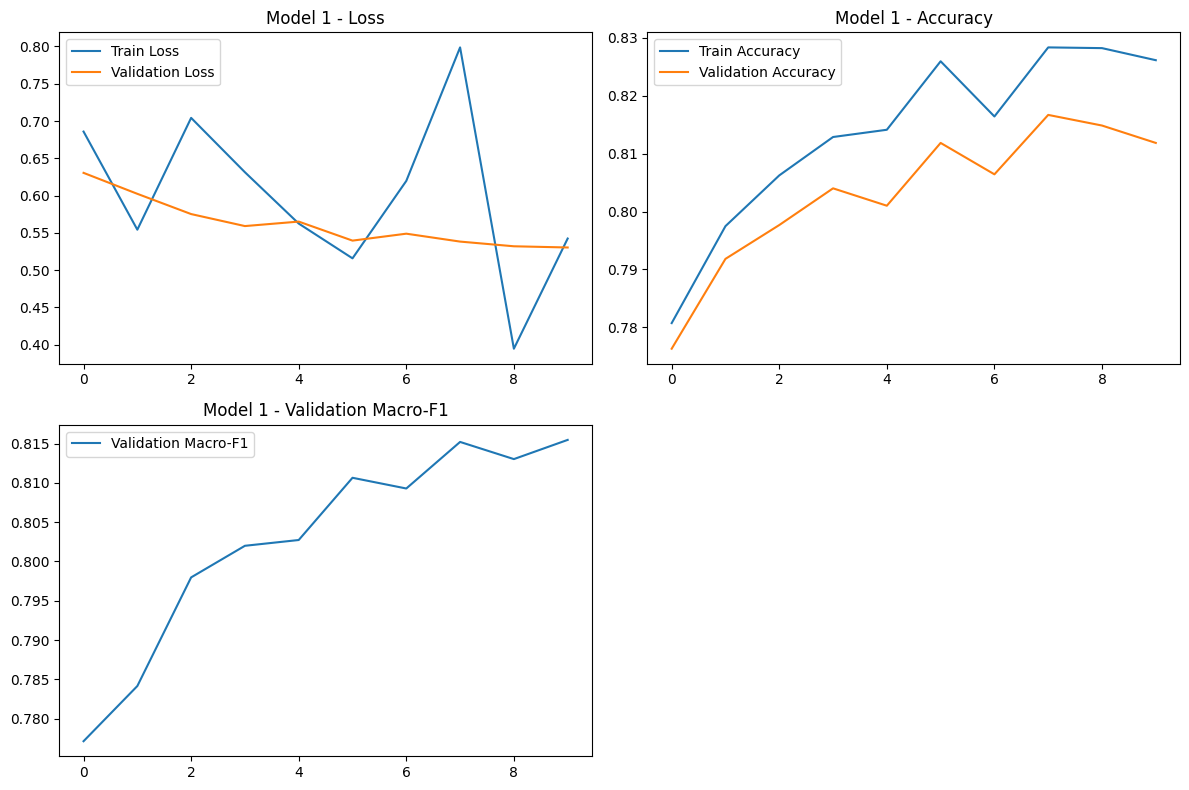

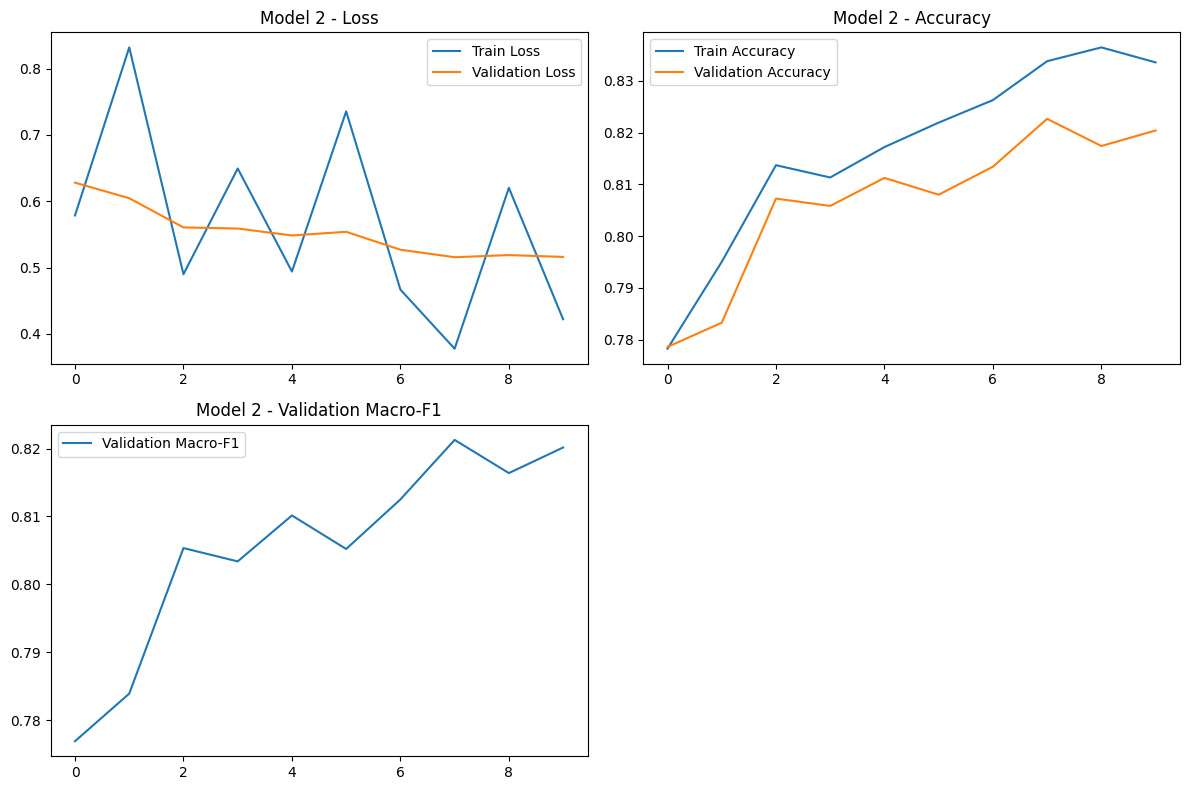

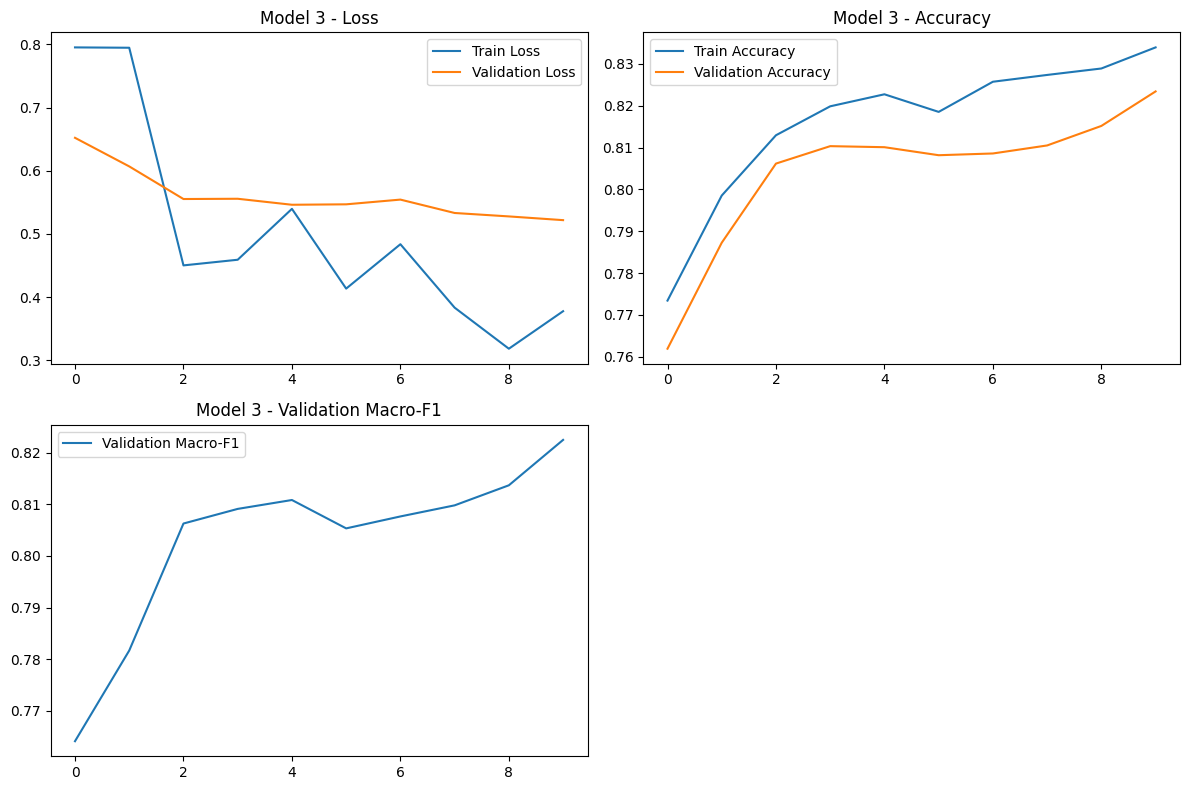

IndexError: list index out of range

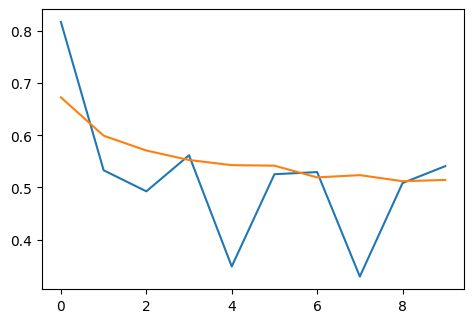

In [14]:


# Define and train models with different learning rates
learning_rates = [0.005, 0.001, 0.0005, 0.0001]
model_names = ['Model 1', 'Model 2', 'Model 3']
histories = []

for lr in learning_rates:
    for model_name in model_names:
        # Define network layers
        layers = [
            DenseLayer(input_dim, 128),
            ReLU(),
            BatchNormalization(128),
            Dropout(0.5),
            DenseLayer(128, 64),
            ReLU(),
            BatchNormalization(64),
            Dropout(0.5),
            DenseLayer(64, output_dim),
            Softmax()
        ]
        
        # Initialize the neural network and optimizer
        network = NeuralNetwork(layers)
        optimizer = Adam(learning_rate=lr)
        
        # Train the model
        history = train(network, X_train, y_train, X_val, y_val, epochs=10, batch_size=64, learning_rate=lr, optimizer=optimizer)
        histories.append(history)
        
        # Evaluate the model
        accuracy, f1, conf_matrix = evaluate(network, X_test, y_test)
        print(f"Learning Rate: {lr}, Model: {model_name}, Test Accuracy: {accuracy:.4f}, Macro F1 Score: {f1:.4f}")
        print("Confusion Matrix:\n", conf_matrix)

# Plot metrics for all models and learning rates
plot_metrics(histories, learning_rates, model_names)

# Select the best model based on validation macro-f1 score
best_model_index = np.argmax([max(history['val_f1']) for history in histories])
best_model = histories[best_model_index]

# Report the independent test performance for the best model
best_accuracy, best_f1, best_conf_matrix = evaluate(network, X_test, y_test)
print(f"Best Model Test Accuracy: {best_accuracy:.4f}, Macro F1 Score: {best_f1:.4f}")
print("Best Model Confusion Matrix:\n", best_conf_matrix)

# Save the best model
save_model(network, 'best_model.pickle')
